<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week5_FeatureEngineering_and_ModelSelection_bank_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

|--- Auto <= 0.50
|   |--- Student <= 0.50
|   |   |--- Small Business <= 0.50
|   |   |   |--- Personal <= 0.50
|   |   |   |   |--- Credit Card <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Credit Card >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Personal >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Small Business >  0.50
|   |   |   |--- class: 0
|   |--- Student >  0.50
|   |   |--- class: 0
|--- Auto >  0.50
|   |--- class: 0

Accuracy predicting loan default from loan type: 0.77
Accuracy with LoanTypeDefaultLast: 0.77
Accuracy with names + historical default + amount: 0.63
Random Forest Accuracy: 0.64
Best Grid Search Accuracy: 0.76
RandomForestClassifier(max_features='log2', min_samples_leaf=6, random_state=14)


<Figure size 1000x600 with 0 Axes>

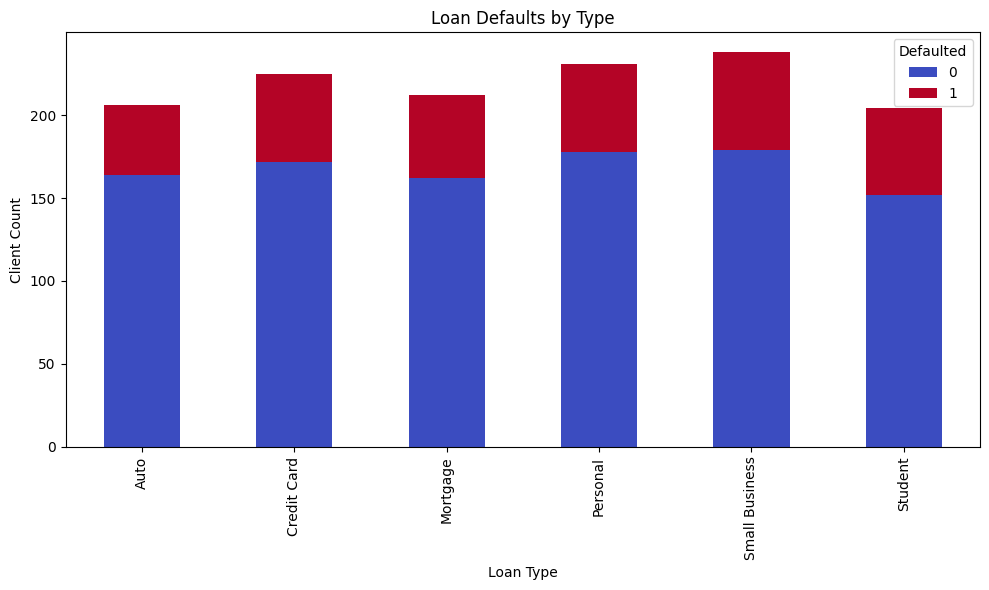

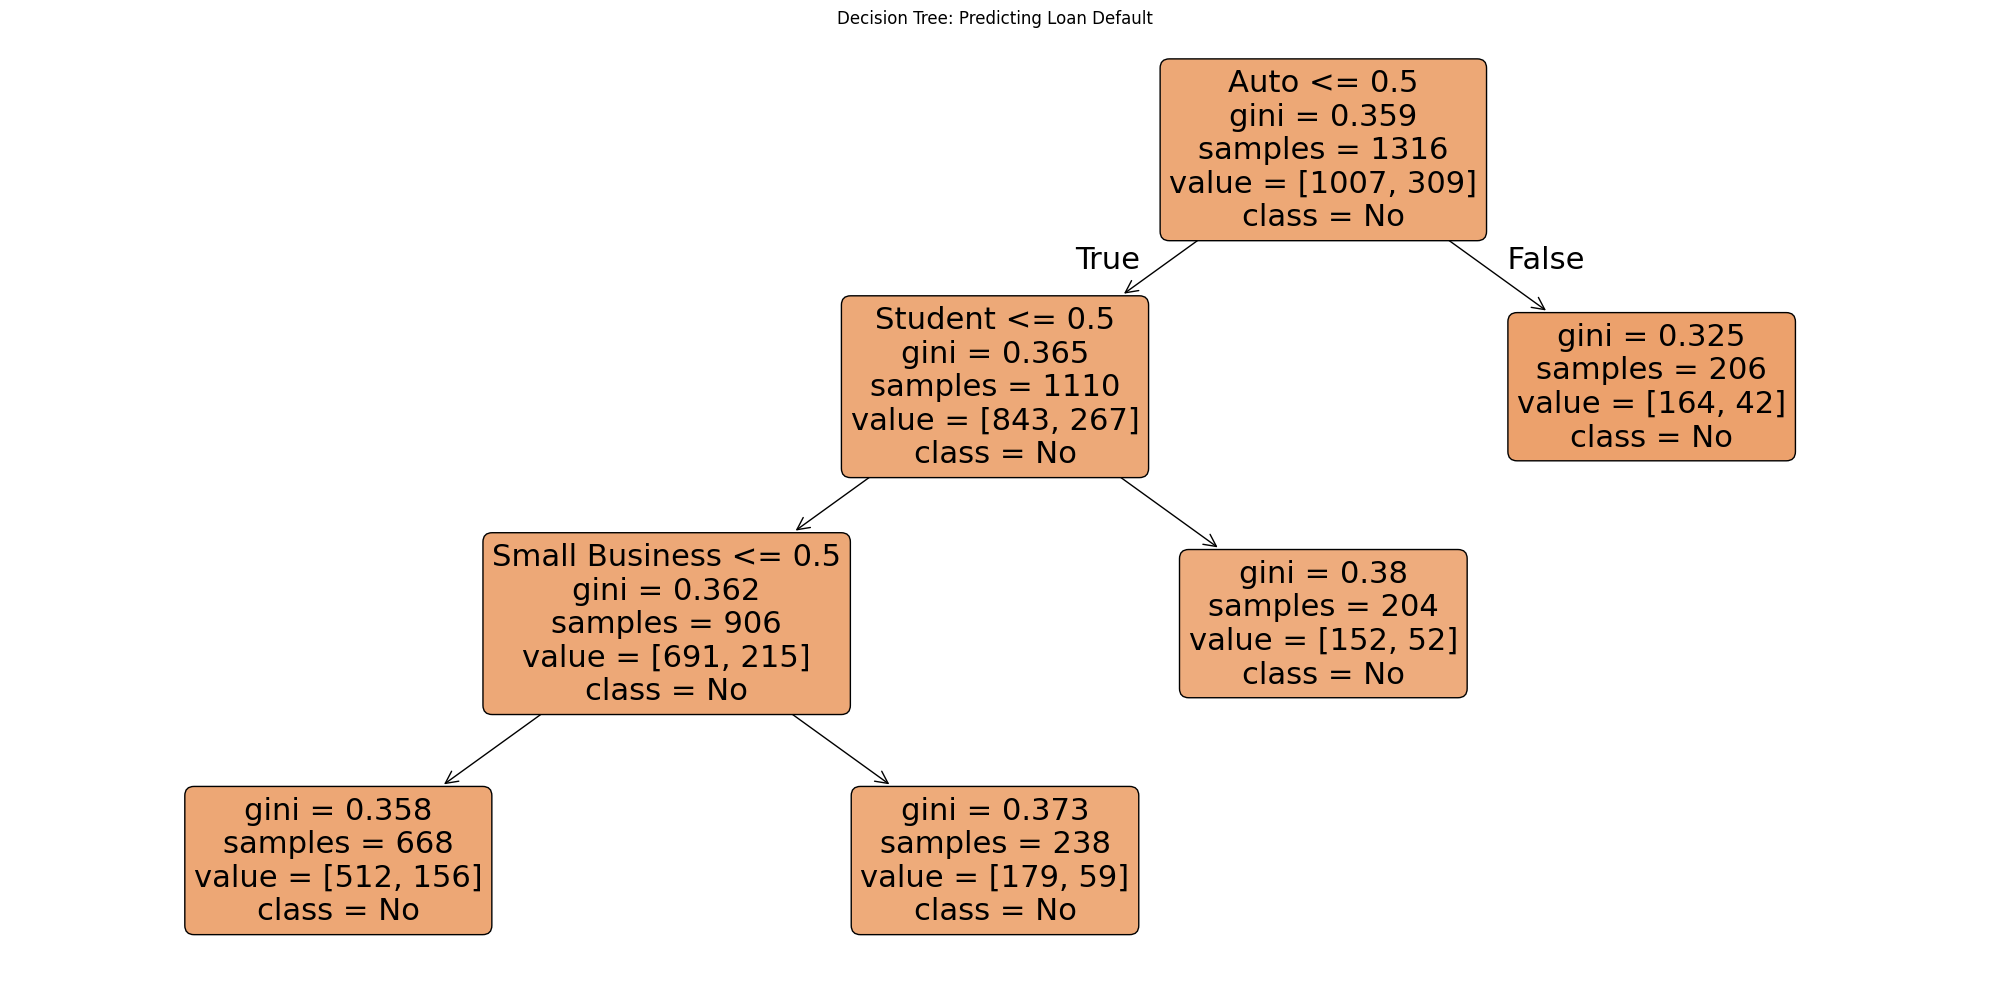

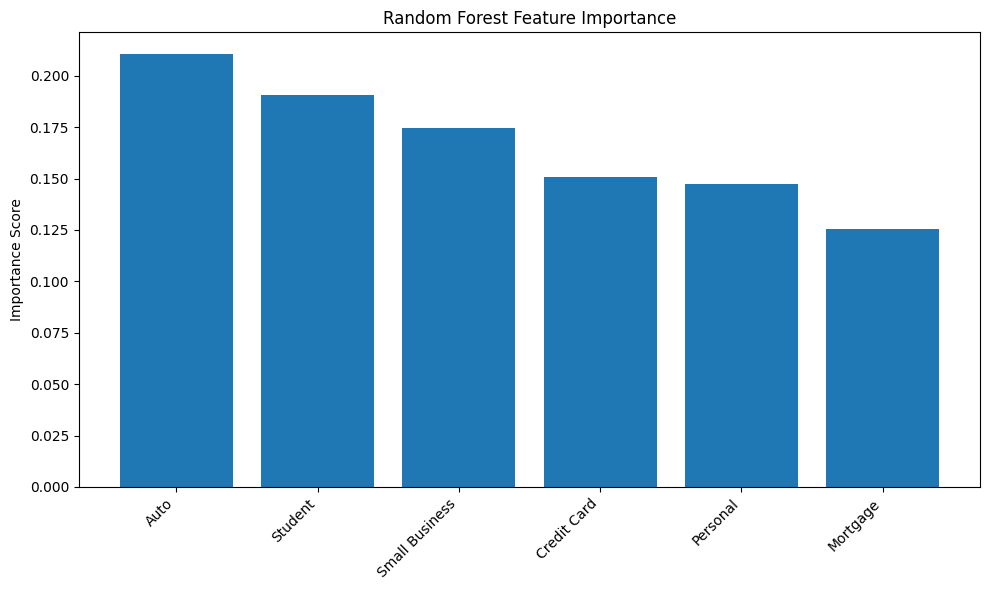

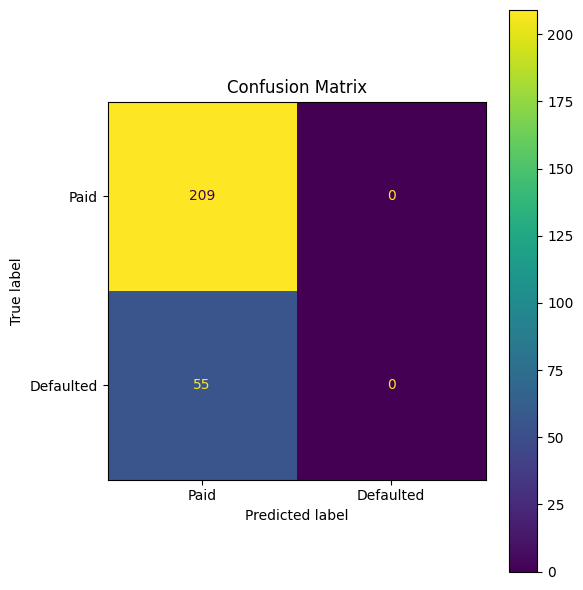

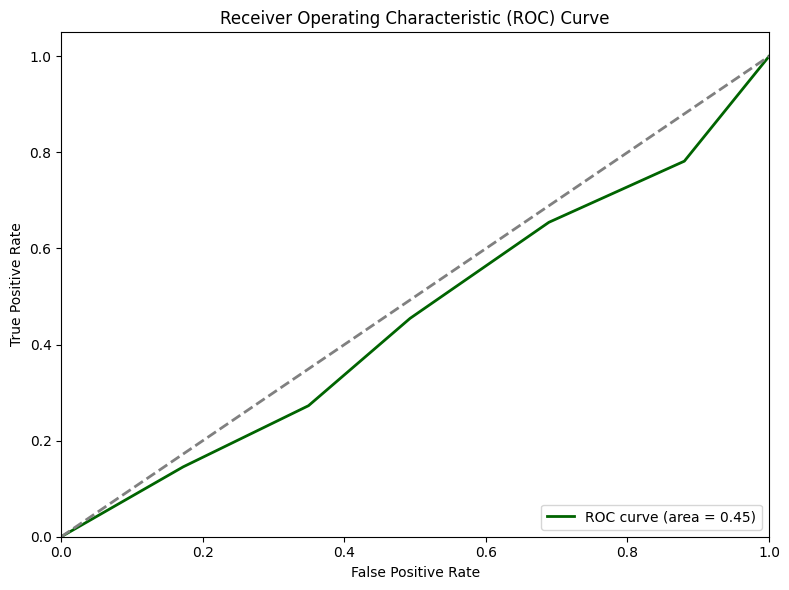

In [1]:
# 🏦 BANK LOAN DEFAULT PREDICTION NOTEBOOK

# 1. Imports and Synthetic Data Creation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

n_clients = 1316
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=int(i)) for i in np.random.randint(0, 180, size=n_clients)]
loan_types = ["Personal", "Mortgage", "Auto", "Student", "Credit Card", "Small Business"]
loan_type = np.random.choice(loan_types, size=n_clients)
age = np.random.randint(18, 75, size=n_clients)
loan_amount = np.random.randint(1000, 100000, size=n_clients)
defaulted = np.random.choice([0, 1], size=n_clients, p=[0.75, 0.25])

df = pd.DataFrame({
    "Loan Date": dates,
    "Loan Type": loan_type,
    "Age": age,
    "Loan Amount": loan_amount,
    "Defaulted": defaulted
})
df.head()

# 2. One-hot Encoding
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[["Loan Type"]])
X = onehot.transform(df[["Loan Type"]]).toarray()
y_default = df["Defaulted"].values

# 3. Basic Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_bank = DecisionTreeClassifier()
dt_bank.fit(X, y_default)

# 4. Textual Tree View
from sklearn.tree import export_text
print(export_text(dt_bank, feature_names=onehot.categories_[0]))

# 5. Train-Test Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_default, test_size=0.2, random_state=42)
dt_bank = DecisionTreeClassifier()
dt_bank.fit(X_train, y_train)
y_pred = dt_bank.predict(X_test)
accuracy_score(y_test, y_pred)

# 6. Cross Validation
from sklearn.model_selection import cross_val_score
dt_bank = DecisionTreeClassifier()
scores = cross_val_score(dt_bank, X, y_default, cv=10, scoring='accuracy')
print("Accuracy predicting loan default from loan type: {:.2f}".format(np.mean(scores)))

# 7. Add Historical Default Feature
df['LoanTypeDefaultLast'] = 0
from collections import defaultdict
last_default = defaultdict(int)

for index, row in df.sort_values("Loan Date").iterrows():
    lt = row['Loan Type']
    df.at[index, 'LoanTypeDefaultLast'] = last_default[lt]
    last_default[lt] = row['Defaulted']

# 8. Accuracy with Historical Default Alone
X_hist = df[['LoanTypeDefaultLast']]
scores = cross_val_score(DecisionTreeClassifier(), X_hist, y_default, scoring='accuracy', cv=10)
print("Accuracy with LoanTypeDefaultLast: {:.2f}".format(np.mean(scores)))

# 9. Combined Features
name_onehot = pd.get_dummies(df['Loan Type'])
X_combined = pd.concat([name_onehot, df[['LoanTypeDefaultLast', 'Loan Amount']]], axis=1)
dt_bank = DecisionTreeClassifier()
scores = cross_val_score(dt_bank, X_combined, y_default, scoring='accuracy', cv=10)
print("Accuracy with names + historical default + amount: {:.2f}".format(np.mean(scores)))

# 10. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=14)
scores = cross_val_score(rf, X_combined, y_default, scoring='accuracy', cv=10)
print("Random Forest Accuracy: {:.2f}".format(np.mean(scores)))

# 11. Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2, 4, 6],
}
grid = GridSearchCV(RandomForestClassifier(random_state=14), param_grid)
grid.fit(X_combined, y_default)
print("Best Grid Search Accuracy: {:.2f}".format(grid.best_score_))
print(grid.best_estimator_)

# 12. Final Accuracy
final_model = grid.best_estimator_
y_pred_final = final_model.predict(X_combined)
accuracy_score(y_default, y_pred_final)

# 13. Visualization
import matplotlib.pyplot as plt

# Bar Chart
plt.figure(figsize=(10, 6))
df_grouped = df.groupby(['Loan Type', 'Defaulted']).size().unstack(fill_value=0)
df_grouped.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))
plt.title("Loan Defaults by Type")
plt.xlabel("Loan Type")
plt.ylabel("Client Count")
plt.tight_layout()
plt.show()

# 14. Decision Tree Visualization
from sklearn.tree import plot_tree

X_dept = onehot.fit_transform(df[["Loan Type"]]).toarray()
y_default = df["Defaulted"].values
dt_model = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_model.fit(X_dept, y_default)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_model, feature_names=onehot.categories_[0], class_names=["No", "Yes"],
          filled=True, rounded=True, ax=ax)
plt.title("Decision Tree: Predicting Loan Default")
plt.tight_layout()
plt.show()

# 15. Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_dept, y_default)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = np.array(onehot.categories_[0])[indices]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(importances)), importances[indices], align='center')
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_title("Random Forest Feature Importance")
ax.set_ylabel("Importance Score")
plt.tight_layout()
plt.show()

# 16. Evaluation: Confusion Matrix + ROC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X_dept, y_default, test_size=0.2, random_state=0)
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Paid", "Defaulted"]).plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()
